<a href="https://colab.research.google.com/github/Bakti-Abdul-Nafi/Analisis-Sentimen-UUCK/blob/main/Youtube_(Predict)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import sys 
import pandas as pd
import tensorflow
import sklearn as sk
import numpy as np
import re
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
nltk.download('stopwords')


check_gpu = len(tf.config.list_physical_devices('GPU'))>0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Model & Tokenizer Load

In [ ]:
# load model
model=load_model('BestModel.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          144000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
# loading
!pip3 install pickle5
import pickle5 as pickle

with open('tokenizer2.pickle', 'rb') as handle:
    tokenizer1 = pickle.load(handle)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 8.0 MB/s 


#Data Preprocessing and Cleaning

Dataset Sebelum

In [ ]:
df1 = pd.read_csv('/content/Dataset Sentimen Analisis - Sebelum Pengesahan Yt.csv')

In [ ]:
#df1.drop(df1.columns[[0,1,3,4,5,6,7]], axis=1, inplace=True)

In [ ]:
df1

,Name,Comment
0,agus johan,Maksdxa BPJS jetenaga kerjaan skrang pengusaha...
1,agus johan,Bahkan sekarang kainbpengusaha. TDK mendaftar...
2,agus johan,Pemberian THR tlong di awasi pak maksih
3,agus johan,Kami usul pak penfawasan pemberian upah dan...
4,Kyara Putri inshafiana,Ump naik engga ada 1% sehat boss
...,...,...
42695,Your Viewer,Asik juga 6 hari kerja
42696,aep syaipudin,gak bisa ngomong lagi aku
42697,Jzun LF,"Ya udah lewat ketikan aja bang😁 tpi hati"" taku..."
42698,noname,@Danielcln waduh wkwkw


Dataset Sesudah

In [ ]:
df2 = pd.read_csv('/content/Dataset Sentimen Analisis - Sesudah Pengesahan Yt.csv')

In [ ]:
#df2.drop(df2.columns[[0,1,3,4,5,6,7]], axis=1, inplace=True)

In [ ]:
df2

,Name,Comment
0,Hando yono,"UUD 1945 pasal 33, Perekonomian disusun sebaga..."
1,Habra sitnjak,Berarti d negara ini mk yg punya kuasa
2,Habra sitnjak,Dimana pancasilais mk keadilan bagi seluruh ra...
3,Habra sitnjak,Mk tdk mndukung rakyat dn buruh
4,Habra sitnjak,Uu ciptaker itu sdh sesuai dngan uu 45
...,...,...
2775,Olhin Bocco,Betulll...betull..betull
2776,Abdullah El Rafif,Tullllll
2777,broto koentjahya,"Pemerintah, DPR seharusnya pro buruh\nBuruh ad..."
2778,Kan Robertus,"Undang2, MK mau,.bantai eh, .. ntar dulu itu e..."


In [ ]:
# Implementasi Regular Expression untuk menghapus simbol dan emoji
def normalisasi(text):
  text = re.sub(r'@[A-za-z0-9]+', '', text) #removing @mentions
  text = re.sub('[0-9]+', '', text) #removing number
  text = re.sub(r'#', '', text) #removing '#' symbol
  text = re.sub(r'RT[\s]+', '', text) #removing RT
  text = re.sub(r'#', '', text) #removing '#' symbol
  text = re.sub(r'[\n]+', '', text) #remove new line
  text = re.sub(r"^\s+|\s+$", "", text) #remove leading and trailing spaces in a word using OR sign to delete both
  text = re.sub(r" +", " ", text) #remove multiple space betwen words
  text = re.sub(r'http\S+', '', text) #yang ini yang buat remove https
  text = re.sub(r"\b[a-zA-Z]\b", "", text) #removing single char
  text = re.sub('\s+', ' ', text) #removing multiple whitespace
  text = re.sub(r'\W', " ", text)
  text = text.replace('\\t', ' ').replace('\\n', ' ').replace('\\u', ' ').replace('\\', ' ')#remove tab, new line, and back slice
  text = re.sub(r'[^\w\s]', ' ', text) #remove puntuation $ emoji (remove all besides \w > word dan \s > space)
  text = re.sub(r"²|¹|³|⁰|ⁱ|⁴|⁵|⁶|⁷|⁸|⁹|⁺|⁻|⁽|⁾|ⁿ]+", "", text) #ilangin pangkat
  text = re.sub(r'_', '',text) #ilangin garisbawah
  text = text.translate(str.maketrans("", "", string.punctuation)) #ilangin punctuation(,:';)
  return text

# Fungsi menghapus karakter berulang
def replace_repeat_character(text):
    # Pattern to look for three or more repetitions of any character, including newlines (contoh goool -> gol).
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1", text)

# Merubah kata alay menjadi kata baku
dict = {row[0] : row[1] for _, row in pd.read_csv("kbba.txt", delimiter = "\t").iterrows()}

def kbbi(text): 
    token = text.split()
    final_string = ' '.join(str(dict.get(word, word)) for word in token)
    return final_string

# Menghapus baris yang mengandung noise
def noise(text): 
    text = text.split()
    listStopword =['amp', 'tong', 'fry', 'vcs', 'bahh', 'a', 'wkwkwk', 'c', 'yeey', 'oi', 'pret', 'iya', 'nya', 'sih', 'mbok',
                   'ku', 'loh', 'lho', 'ah', 'nihh', 'mares', 'openbo','ya', 'hah', 'joss', 'deh''rmp', 'v', 'via', 'lha', 'mah',
                   'xixi','username', 'ilc','ilctvone','hitamputih', 'hitamputiht7','kickandy', 'metro', 'metrotv','at', 'kickandymetrotv',
                   'tvmatanajwa','matanajwametrotv', 'usermention','user','mention','providername','url','g','gb','yang','dan','nya','ya',
                   'smiling','ok','hand','provider','name','providername', 'andy','najwa','shihab','sihab', 'di', 'dan','ini','fpi','mikhayla',
                   'ada','adalah','adanya','adapun','agak','agaknya','agar','akan','akankah','akhir','akhiri','akhirnya','aku','akulah',
                   'amat','amatlah','anda','andalah','antar','antara','antaranya','apa','apaan','apabila','apakah','apalagi','apatah',
                   'artinya','asal','asalkan','atas','atau','ataukah','ataupun','awal','awalnya','bagai','bagaikan','bagaimana',
                   'bagaimanakah','bagaimanapun','bagi','bagian','bahkan','bahwa','bahwasanya','baik','bakal','bakalan','balik','banyak',
                   'bapak','baru','bawah','beberapa','begini','beginian','beginikah','beginilah','begitu','begitukah','begitulah',
                   'begitupun','bekerja','belakang','belakangan','belum','belumlah','benar','benarkah','benarlah','berada','berakhir',
                   'berakhirlah','berakhirnya','berapa','berapakah','berapalah','berapapun','berarti','berawal','berbagai','berdatangan',
                   'beri','berikan','berikut','berikutnya','berjumlah','berkali-kali','berkata','berkehendak','berkeinginan','berkenaan',
                   'berlainan','berlalu','berlangsung','berlebihan','bermacam','bermacam-macam','bermaksud','bermula','bersama',
                   'bersama-sama','bersiap','bersiap-siap','bertanya','bertanya-tanya','berturut','berturut-turut','bertutur','berujar',
                   'berupa','besar','betul','betulkah','biasa','biasanya','bila','bilakah','bisa','bisakah','boleh','bolehkah','bolehlah',
                   'buat','bukan','bukankah','bukanlah','bukannya','bulan','bung','cara','caranya','cukup','cukupkah','cukuplah','cuma',
                   'dahulu','dalam','dan','dapat','dari','daripada','datang','dekat','demi','demikian','demikianlah','dengan','depan','di',
                   'dia','diakhiri','diakhirinya','dialah','diantara','diantaranya','diberi','diberikan','diberikannya','dibuat',
                   'dibuatnya','didapat','didatangkan','digunakan','diibaratkan','diibaratkannya','diingat','diingatkan','diinginkan',
                   'dijawab','dijelaskan','dijelaskannya','dikarenakan','dikatakan','dikatakannya','dikerjakan','diketahui','diketahuinya',
                   'dikira','dilakukan','dilalui','dilihat','dimaksud','dimaksudkan','dimaksudkannya','dimaksudnya','diminta','dimintai',
                   'dimisalkan','dimulai','dimulailah','dimulainya','dimungkinkan','dini','dipastikan','diperbuat','diperbuatnya',
                   'dipergunakan','diperkirakan','diperlihatkan','diperlukan','diperlukannya','dipersoalkan','dipertanyakan','dipunyai',
                   'diri','dirinya','disampaikan','disebut','disebutkan','disebutkannya','disini','disinilah','ditambahkan','ditandaskan',
                   'ditanya','ditanyai','ditanyakan','ditegaskan','ditujukan','ditunjuk','ditunjuki','ditunjukkan','ditunjukkannya',
                   'ditunjuknya','dituturkan','dituturkannya','diucapkan','diucapkannya','diungkapkan','dong','dua','dulu','empat',
                   'enggak','enggaknya','entah','entahlah','guna','gunakan','hal','hampir','hanya','hanyalah','hari','harus','haruslah',
                   'harusnya','hendak','hendaklah','hendaknya','hingga','ia','ialah','ibarat','ibaratkan','ibaratnya','ibu','ikut','ingat',
                   'ingat-ingat','ingin','inginkah','inginkan','ini','inikah','inilah','itu','itukah','itulah','jadi','jadilah','jadinya',
                   'jangan','jangankan','janganlah','jauh','jawab','jawaban','jawabnya','jelas','jelaskan','jelaslah','jelasnya','jika',
                   'jikalau','juga','jumlah','jumlahnya','justru','kala','kalau','kalaulah','kalaupun','kalian','kami','kamilah','kamu',
                   'kamulah','kan','kapan','kapankah','kapanpun','karena','karenanya','kasus','kata','katakan','katakanlah','katanya',
                   'ke','keadaan','kebetulan','kecil','kedua','keduanya','keinginan','kelamaan','kelihatan','kelihatannya','kelima',
                   'keluar','kembali','kemudian','kemungkinan','kemungkinannya','kenapa','kepada','kepadanya','kesampaian','keseluruhan',
                   'keseluruhannya','keterlaluan','ketika','khususnya','kini','kinilah','kira','kira-kira','kiranya','kita','kitalah',
                   'kok','kurang','lagi','lagian','lah','lain','lainnya','lalu','lama','lamanya','lanjut','lanjutnya','lebih','lewat',
                   'lima','luar','macam','maka','makanya','makin','malah','malahan','mampu','mampukah','mana','manakala','manalagi','masa',
                   'masalah','masalahnya','masih','masihkah','masing','masing-masing','mau','maupun','melainkan','melakukan','melalui',
                   'melihat','melihatnya','memang','memastikan','memberi','memberikan','membuat','memerlukan','memihak','meminta',
                   'memintakan','memisalkan','memperbuat','mempergunakan','memperkirakan','memperlihatkan','mempersiapkan','mempersoalkan',
                   'mempertanyakan','mempunyai','memulai','memungkinkan','menaiki','menambahkan','menandaskan','menanti','menanti-nanti',
                   'menantikan','menanya','menanyai','menanyakan','mendapat','mendapatkan','mendatang','mendatangi','mendatangkan',
                   'menegaskan','mengakhiri','mengapa','mengatakan','mengatakannya','mengenai','mengerjakan','mengetahui','menggunakan',
                   'menghendaki','mengibaratkan','mengibaratkannya','mengingat','mengingatkan','menginginkan','mengira','mengucapkan',
                   'mengucapkannya','mengungkapkan','menjadi','menjawab','menjelaskan','menuju','menunjuk','menunjuki','menunjukkan',
                   'menunjuknya','menurut','menuturkan','menyampaikan','menyangkut','menyatakan','menyebutkan','menyeluruh','menyiapkan',
                   'merasa','mereka','merekalah','merupakan','meski','meskipun','meyakini','meyakinkan','minta','mirip','misal','misalkan',
                   'misalnya','mula','mulai','mulailah','mulanya','mungkin','mungkinkah','nah','naik','namun','nanti','nantinya','nyaris',
                   'nyatanya','oleh','olehnya','pada','padahal','padanya','pak','paling','panjang','pantas','para','pasti','pastilah',
                   'penting','pentingnya','per','percuma','perlu','perlukah','perlunya','pernah','persoalan','pertama','pertama-tama',
                   'pertanyaan','pertanyakan','pihak','pihaknya','pukul','pula','pun','punya','rasa','rasanya','rata','rupanya','saat',
                   'saatnya','saja','sajalah','saling','sama','sama-sama','sambil','sampai','sampai-sampai','sampaikan','sana','sangat',
                   'sangatlah','satu','saya','sayalah','se','sebab','sebabnya','sebagai','sebagaimana','sebagainya','sebagian','sebaik',
                   'sebaik-baiknya','sebaiknya','sebaliknya','sebanyak','sebegini','sebegitu','sebelum','sebelumnya','sebenarnya',
                   'seberapa','sebesar','sebetulnya','sebisanya','sebuah','sebut','sebutlah','sebutnya','secara','secukupnya','sedang',
                   'sedangkan','sedemikian','sedikit','sedikitnya','seenaknya','segala','segalanya','segera','seharusnya','sehingga',
                   'seingat','sejak','sejauh','sejenak','sejumlah','sekadar','sekadarnya','sekali','sekali-kali','sekalian','sekaligus',
                   'sekalipun','sekarang','sekarang','sekecil','seketika','sekiranya','sekitar','sekitarnya','sekurang-kurangnya',
                   'sekurangnya','sela','selain','selaku','selalu','selama','selama-lamanya','selamanya','selanjutnya','seluruh',
                   'seluruhnya','semacam','semakin','semampu','semampunya','semasa','semasih','semata','semata-mata','semaunya','sementara',
                   'semisal','semisalnya','sempat','semua','semuanya','semula','sendiri','sendirian','sendirinya','seolah','seolah-olah',
                   'seorang','sepanjang','sepantasnya','sepantasnyalah','seperlunya','seperti','sepertinya','sepihak','sering','seringnya',
                   'serta','serupa','sesaat','sesama','sesampai','sesegera','sesekali','seseorang','sesuatu','sesuatunya','sesudah',
                   'sesudahnya','setelah','setempat','setengah','seterusnya','setiap','setiba','setibanya','setidak-tidaknya','setidaknya',
                   'setinggi','seusai','sewaktu','siap','siapa','siapakah','siapapun','sini','sinilah','soal','soalnya','suatu','sudah',
                   'sudahkah','sudahlah','supaya','tadi','tadinya','tahu','tahun','tak','tambah','tambahnya','tampak','tampaknya','tandas',
                   'tandasnya','tanpa','tanya','tanyakan','tanyanya','tapi','tegas','tegasnya','telah','tempat','tengah','tentang','tentu',
                   'tentulah','tentunya','tepat','terakhir','terasa','terbanyak','terdahulu','terdapat','terdiri','terhadap','terhadapnya',
                   'teringat','teringat-ingat','terjadi','terjadilah','terjadinya','terkira','terlalu','terlebih','terlihat','termasuk',
                   'ternyata','tersampaikan','tersebut','tersebutlah','tertentu','tertuju','terus','terutama','tetap','tetapi','tiap','tiba',
                   'tiba-tiba','tidak','tidakkah','tidaklah','tiga','tinggi','toh','tunjuk','turut','tutur','tuturnya','ucap','ucapnya'
                   ]
                     
    text = [w for w in text if not w in listStopword]
    text = " ".join(text)
    return text

#Stopword
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwords=set(stopwords.words("indonesian"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data Sebelum cleaning

In [ ]:
# normalisasi
df1['stopword_comment'] = df1['Comment'].apply(lambda x: normalisasi(x))

# Merubah menjadi huruf kecil
df1['stopword_comment'] = df1['stopword_comment'].apply(lambda x: x.lower())

#hapus karakter berulang
df1['stopword_comment'] = df1['stopword_comment'].apply(replace_repeat_character) 

# KBBI
df1['stopword_comment'] = df1['stopword_comment'].apply(lambda x: kbbi(x))

#hapus noise
df1['stopword_comment'] = df1['stopword_comment'].apply(lambda x: noise(x))

#stopword
df1['stopword_comment'] = df1['stopword_comment'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in (stopwords)]))

#Duplikat
df1 = df1.drop_duplicates(subset=['stopword_comment'])

#Drop Missing Value
df1 = df1.dropna(subset=['stopword_comment'])

df1 = df1.astype(str)

In [ ]:
df1

,Name,Comment,stopword_comment
0,agus johan,Maksdxa BPJS jetenaga kerjaan skrang pengusaha...,maksudnya bpjs jetenaga kerja pengusaha tdj sr...
1,agus johan,Bahkan sekarang kainbpengusaha. TDK mendaftar...,pengusaha mendaftarkan bpjs ketenaga kerja
2,agus johan,Pemberian THR tlong di awasi pak maksih,pemberian thr tolong awasi maksih
3,agus johan,Kami usul pak penfawasan pemberian upah dan...,usul pengawasan pemberian upah the propinsin d...
4,Kyara Putri inshafiana,Ump naik engga ada 1% sehat boss,ump sehat bos
...,...,...,...
42692,Game Ringan,Bos situ buruh apa pengusaha? Kok nyalahin SDM...,bos situ buruh pengusaha salah sdm meningkatka...
42693,oncom,"Lama ga sidang, sekali sidang bikin gaduh buruh",sidang sidang bikin gaduh buruh
42695,Your Viewer,Asik juga 6 hari kerja,asik kerja
42697,Jzun LF,"Ya udah lewat ketikan aja bang😁 tpi hati"" taku...",ketikan bang hati takut kena


Data sesudah cleaning

In [ ]:
# normalisasi
df2['stopword_comment'] = df2['Comment'].apply(lambda x: normalisasi(x))

# Merubah menjadi huruf kecil
df2['stopword_comment'] = df2['stopword_comment'].apply(lambda x: x.lower())

#hapus karakter berulang
df2['stopword_comment'] = df2['stopword_comment'].apply(replace_repeat_character) 

# KBBI
df2['stopword_comment'] = df2['stopword_comment'].apply(lambda x: kbbi(x))

#hapus noise
df2['stopword_comment'] = df2['stopword_comment'].apply(lambda x: noise(x))

#stopword
df2['stopword_comment'] = df2['stopword_comment'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in (stopwords)]))

#Duplikat
df2 = df2.drop_duplicates(subset=['stopword_comment'])

#Drop Missing Value
df2 = df2.dropna(subset=['stopword_comment'])

df2 = df2.astype(str)

In [ ]:
df2

,Name,Comment,stopword_comment
0,Hando yono,"UUD 1945 pasal 33, Perekonomian disusun sebaga...",pasal perekonomian disusun usaha azas kekeluar...
1,Habra sitnjak,Berarti d negara ini mk yg punya kuasa,negara mk kuasa
2,Habra sitnjak,Dimana pancasilais mk keadilan bagi seluruh ra...,dimana pancasilais mk keadilan rakyat indonesia
3,Habra sitnjak,Mk tdk mndukung rakyat dn buruh,mk mendukung rakyat dn buruh
4,Habra sitnjak,Uu ciptaker itu sdh sesuai dngan uu 45,ciptaker sesuai
...,...,...,...
2773,kunk odi,Comments\n\nAdd a public comment...\n\n\nkunk ...,comentsad public coment kunk odi minutes agoky...
2774,Farel Fafian,"Karena rezim rata"" pengusaha,,,jd akal bulus e...",rezim pengusaha akal bulus pdi berkuasa harap ...
2777,broto koentjahya,"Pemerintah, DPR seharusnya pro buruh\nBuruh ad...",pemerintah dpr profesional buruhburuh rakyat i...
2778,Kan Robertus,"Undang2, MK mau,.bantai eh, .. ntar dulu itu e...",undang mk bantai eh sebentar eksistensi berlak...


#Predict Kata dengan model

In [ ]:
ytb = ['alhamdulillah, sehat selalu pak']
print(ytb)
#vectorizing the comment  by the pre-fitted tokenizer instance
ytb = tokenizer1.texts_to_sequences(ytb)
#padding the comment to have exactly the same shape as `embedding_2` input
ytb = pad_sequences(ytb, maxlen=29, dtype='int32', value=0)

sentiment = model.predict(ytb)
print(sentiment)
print(np.rint(sentiment))

if(np.rint(sentiment) == 0):
    print('Sentimen: Negatif')
else :
    print('Sentimen: Positif')

['alhamdulillah, sehat selalu pak']
[[0.95683193]]
[[1.]]
Sentimen: Positif


In [ ]:
def convert(text):
  yt = [text]
  yt = tokenizer1.texts_to_sequences(yt)
  yt = pad_sequences(yt, maxlen=29, dtype='int32', value=0)
  sentiment = model.predict(yt)
  if(np.rint(sentiment) == 0):
      return 'Negatif'
  else :
     return 'Positif'

#Predict Data Sebelum dengan model

In [ ]:
t_sebelum = df1
t_sebelum['Hasil Sentimen'] =t_sebelum['stopword_comment'].apply(lambda x: convert(x))

In [ ]:
t_sebelum.head(5)

,Name,Comment,stopword_comment,Hasil Sentimen
0,agus johan,Maksdxa BPJS jetenaga kerjaan skrang pengusaha...,maksudnya bpjs jetenaga kerja pengusaha tdj sr...,Positif
1,agus johan,Bahkan sekarang kainbpengusaha. TDK mendaftar...,pengusaha mendaftarkan bpjs ketenaga kerja,Positif
2,agus johan,Pemberian THR tlong di awasi pak maksih,pemberian thr tolong awasi maksih,Negatif
3,agus johan,Kami usul pak penfawasan pemberian upah dan...,usul pengawasan pemberian upah the propinsin d...,Negatif
4,Kyara Putri inshafiana,Ump naik engga ada 1% sehat boss,ump sehat bos,Positif


Visualisasi Sentimen

In [ ]:
senti_count = t_sebelum['Hasil Sentimen'].value_counts()
print(type(senti_count))
print(senti_count)

<class 'pandas.core.series.Series'>
Negatif    28055
Positif    11417
Name: Hasil Sentimen, dtype: int64


In [ ]:
senti_count2=list(zip(str(senti_count),str(senti_count.index)))
senti_count2=tuple(zip(senti_count,senti_count.index))
kolom=[(sub[1], sub[0]) for sub in senti_count2]
kolom

[('Negatif', 28055), ('Positif', 11417)]

In [ ]:
labels=[]
values=[]
for row in kolom:
    labels.append(row[0])
    values.append(row[1])
print(labels)
print(values)

['Negatif', 'Positif']
[28055, 11417]


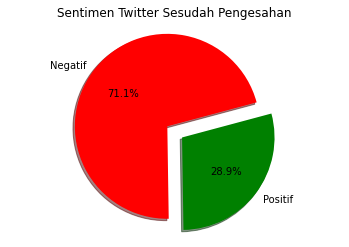

In [ ]:
my_labels = 'Negatif','Positif'
my_colors = ['red','green']
my_explode = (0.1, 0.1)
plt.pie(senti_count, labels=my_labels, autopct='%1.1f%%', startangle=15, shadow = True, colors=my_colors, explode=my_explode)
plt.title('Sentimen Twitter Sesudah Pengesahan')
plt.axis('equal')
plt.show()

In [ ]:
# split df - positive and negative sentiment:
positive1 = t_sebelum[t_sebelum['Hasil Sentimen'] == 'Positif']
negative1 = t_sebelum[t_sebelum['Hasil Sentimen'] == 'Negatif']


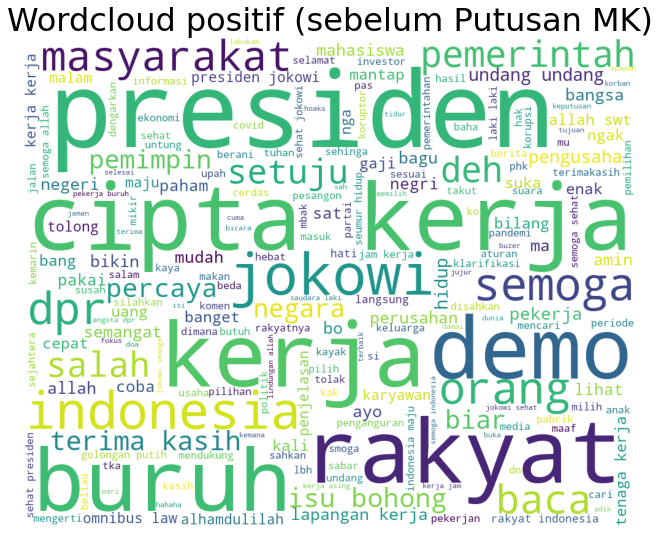

In [ ]:
#Sentimen Positif wordcold
comment_words=''

for val in positive1.stopword_comment:  
    # merubah val menjadi string
    val = str(val)
  
    # memisahkan variabel val per kata
    tokens = val.split() 
      
    # Mengonversi variabel val menjadi huruf kecil
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud1 = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("Wordcloud positif (sebelum Putusan MK)", fontsize = 32)
plt.tight_layout(pad = 1) 

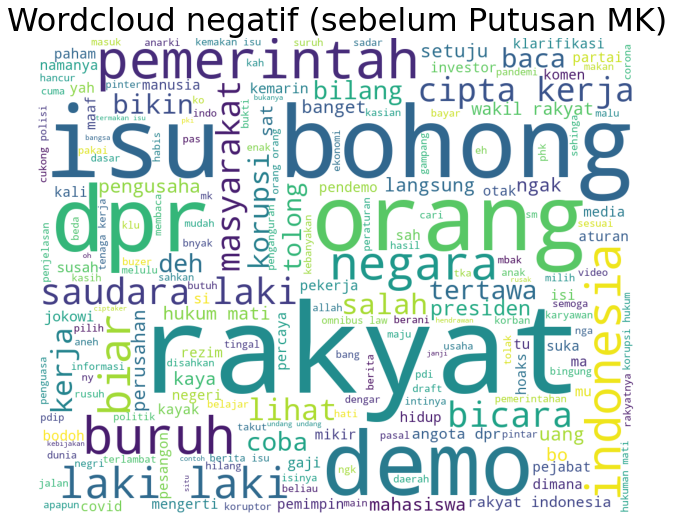

In [ ]:
#Sentimen negatif wordcold
comment_words=''

for val in negative1.stopword_comment:  
    # merubah val menjadi string
    val = str(val)
  
    # memisahkan variabel val per kata
    tokens = val.split() 
      
    # Mengonversi variabel val menjadi huruf kecil
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud2 = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("Wordcloud negatif (sebelum Putusan MK)", fontsize = 32)
plt.tight_layout(pad = 1) 

#Predict Data Sesudah dengan model

In [ ]:
t_sesudah = df2
t_sesudah['Hasil Sentimen'] =t_sesudah['stopword_comment'].apply(lambda x: convert(x))

In [ ]:
t_sesudah.head()

,Name,Comment,stopword_comment,Hasil Sentimen
0,Hando yono,"UUD 1945 pasal 33, Perekonomian disusun sebaga...",pasal perekonomian disusun usaha azas kekeluar...,Positif
1,Habra sitnjak,Berarti d negara ini mk yg punya kuasa,negara mk kuasa,Negatif
2,Habra sitnjak,Dimana pancasilais mk keadilan bagi seluruh ra...,dimana pancasilais mk keadilan rakyat indonesia,Negatif
3,Habra sitnjak,Mk tdk mndukung rakyat dn buruh,mk mendukung rakyat dn buruh,Positif
4,Habra sitnjak,Uu ciptaker itu sdh sesuai dngan uu 45,ciptaker sesuai,Negatif


Visualisasi sentimen

In [ ]:
senti_count = t_sesudah['Hasil Sentimen'].value_counts()
print(type(senti_count))
print(senti_count)

<class 'pandas.core.series.Series'>
Negatif    1880
Positif     813
Name: Hasil Sentimen, dtype: int64


In [ ]:
senti_count2=list(zip(str(senti_count),str(senti_count.index)))
senti_count2=tuple(zip(senti_count,senti_count.index))
kolom=[(sub[1], sub[0]) for sub in senti_count2]
kolom

[('Negatif', 1880), ('Positif', 813)]

In [ ]:
labels=[]
values=[]
for row in kolom:
    labels.append(row[0])
    values.append(row[1])
print(labels)
print(values)

['Negatif', 'Positif']
[1880, 813]


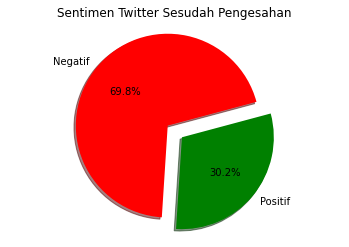

In [ ]:
my_labels = 'Negatif','Positif'
my_colors = ['red','green']
my_explode = (0.1, 0.1)
plt.pie(senti_count, labels=my_labels, autopct='%1.1f%%', startangle=15, shadow = True, colors=my_colors, explode=my_explode)
plt.title('Sentimen Twitter Sesudah Pengesahan')
plt.axis('equal')
plt.show()

In [ ]:
# split df - positive and negative sentiment:
positive = t_sesudah[t_sesudah['Hasil Sentimen'] == 'Positif']
negative = t_sesudah[t_sesudah['Hasil Sentimen'] == 'Negatif']


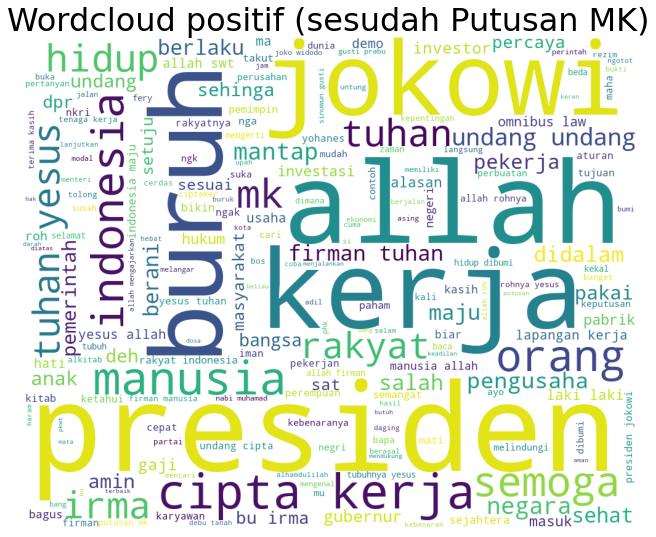

In [ ]:
#Sentimen Positif wordcold
comment_words=''

for val in positive.stopword_comment:  
    # merubah val menjadi string
    val = str(val)
  
    # memisahkan variabel val per kata
    tokens = val.split() 
      
    # Mengonversi variabel val menjadi huruf kecil
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.title("Wordcloud positif (sesudah Putusan MK)", fontsize = 32)
plt.tight_layout(pad = 1) 

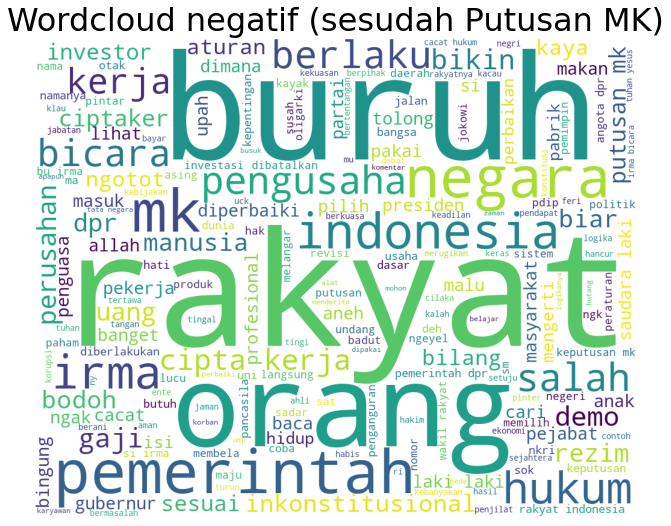

In [ ]:
#Sentimen Negatif wordcold
comment_words=''

for val in negative.stopword_comment:  
    # merubah val menjadi string
    val = str(val)
  
    # memisahkan variabel val per kata
    tokens = val.split() 
      
    # Mengonversi variabel val menjadi huruf kecil
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud4 = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud4) 
plt.axis("off") 
plt.title("Wordcloud negatif (sesudah Putusan MK)", fontsize = 32)
plt.tight_layout(pad = 1) 